In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
from nltk.stem import RSLPStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
import lightgbm as lgb

In [14]:
df = pd.read_csv('/kaggle/input/olistre/olist_order_reviews_dataset.csv')

In [15]:
df

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53
...,...,...,...,...,...,...,...
99219,574ed12dd733e5fa530cfd4bbf39d7c9,2a8c23fee101d4d5662fa670396eb8da,5,NaN,NaN,2018-07-07 00:00:00,2018-07-14 17:18:30
99220,f3897127253a9592a73be9bdfdf4ed7a,22ec9f0669f784db00fa86d035cf8602,5,NaN,NaN,2017-12-09 00:00:00,2017-12-11 20:06:42
99221,b3de70c89b1510c4cd3d0649fd302472,55d4004744368f5571d1f590031933e4,5,NaN,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00,2018-03-23 09:10:43
99222,1adeb9d84d72fe4e337617733eb85149,7725825d039fc1f0ceb7635e3f7d9206,4,NaN,NaN,2018-07-01 00:00:00,2018-07-02 12:59:13


In [21]:
df_comments = df[['review_score','review_comment_message', 'review_creation_date']]

In [20]:
df_comments.dropna()

,review_score,review_comment_message,review_creation_date
3,5,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00
4,5,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00
9,4,aparelho eficiente. no site a marca do aparelh...,2018-05-22 00:00:00
12,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n",2018-02-16 00:00:00
15,5,"Vendedor confiável, produto ok e entrega antes...",2018-05-23 00:00:00
...,...,...,...
99205,4,para este produto recebi de acordo com a compr...,2017-11-29 00:00:00
99208,5,Entregou dentro do prazo. O produto chegou em ...,2018-02-07 00:00:00
99215,3,"O produto não foi enviado com NF, não existe v...",2018-05-19 00:00:00
99221,5,"Excelente mochila, entrega super rápida. Super...",2018-03-22 00:00:00


In [25]:
df_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 3 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   review_score            99224 non-null  int64 
 1   review_comment_message  40977 non-null  object
 2   review_creation_date    99224 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.3+ MB


In [27]:
df_comments = df.loc[:, ['review_score', 'review_comment_message']]
df_comments = df_comments.dropna(subset=['review_comment_message'])
df_comments = df_comments.reset_index(drop=True)
print(f'Dataset shape: {df_comments.shape}')
df_comments.columns = ['score', 'comment']
df_comments.head()

Dataset shape: (40977, 2)


,score,comment
0,5,Recebi bem antes do prazo estipulado.
1,5,Parabéns lojas lannister adorei comprar pela I...
2,4,aparelho eficiente. no site a marca do aparelh...
3,4,"Mas um pouco ,travando...pelo valor ta Boa.\r\n"
4,5,"Vendedor confiável, produto ok e entrega antes..."


In [34]:
def print_step_result(text_list_before, text_list_after, idx_list):

    i = 1
    for idx in idx_list:
        print(f'--- Text {i} ---\n')
        print(f'Antes: \n{text_list_before[idx]}\n')
        print(f'Depois: \n{text_list_after[idx]}\n')
        i += 1

In [35]:
import regex as re
def re_breakline(text_list):
    return [re.sub('[\n\r]', ' ', r) for r in text_list]

reviews = list(df_comments['comment'].values)

reviews_breakline = re_breakline(reviews)
df_comments['re_breakline'] = reviews_breakline

print_step_result(reviews, reviews_breakline, idx_list=[48])

--- Text 1 ---

Antes: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!
Tudo certo!

Att 

Elenice.

Depois: 
Estava faltando apenas um produto, eu recebi hoje , muito obrigada!  Tudo certo!    Att     Elenice.



In [39]:
def re_hiperlinks(text_list):
    
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return [re.sub(pattern, ' link ', r) for r in text_list]

reviews_hiperlinks = re_hiperlinks(reviews_breakline)
df_comments['re_hiperlinks'] = reviews_hiperlinks

print_step_result(reviews_breakline, reviews_hiperlinks, idx_list=[10796, 12782])

--- Text 1 ---

Antes: 
O produto chegou a ser entregue, porém foi recusado, poisja havia cancelado por ter comprado o tamanho errado!

Depois: 
O produto chegou a ser entregue, porém foi recusado, poisja havia cancelado por ter comprado o tamanho errado!

--- Text 2 ---

Antes: 
Muito obrigada lannister 

Depois: 
Muito obrigada lannister 



In [46]:
def re_dates(text_list):
 
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return [re.sub(pattern, ' data ', r) for r in text_list]

reviews_dates = re_dates(reviews_hiperlinks)
df_comments['re_dates'] = reviews_dates

--- Text 1 ---

Antes: 
Ainda não chegou , vou esperar até o dia 26, prazo que me foi dado. Duas estrelas, só por enquanto.

Depois: 
Ainda não chegou , vou esperar até o dia 26, prazo que me foi dado. Duas estrelas, só por enquanto.

--- Text 2 ---

Antes: 
TESTAR O PRODUTO

Depois: 
TESTAR O PRODUTO



In [47]:
def re_money(text_list):

    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return [re.sub(pattern, ' dinheiro ', r) for r in text_list]

reviews_money = re_money(reviews_dates)
df_comments['re_money'] = reviews_money

In [51]:
def re_negation(text_list):
    
    return [re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', r) for r in text_list]

reviews_negation = re_negation(reviews_dates)
df_comments['re_negation'] = reviews_negation

print_step_result(reviews_dates, reviews_negation, idx_list=[4783, 4627, 4856, 4904])

--- Text 1 ---

Antes: 
Ótimo relógio estou bastante satisfeito recomendo a todos essa loja está de parabéns obrigado 

Depois: 
Ótimo relógio estou bastante satisfeito recomendo a todos essa loja está de parabéns obrigado 

--- Text 2 ---

Antes: 
Envio muito rápido e chegou muito rápido também. 

Depois: 
Envio muito rápido e chegou muito rápido também. 

--- Text 3 ---

Antes: 
Gostei do produto. Recomendo.

Depois: 
Gostei do produto. Recomendo.

--- Text 4 ---

Antes: 
Igualzinho o que eu pedi. Lindo

Depois: 
Igualzinho o que eu pedi. Lindo



In [52]:
def re_special_chars(text_list):
    
    return [re.sub('\W', ' ', r) for r in text_list]

reviews_special_chars = re_special_chars(reviews_negation)
df_comments['re_special_chars'] = reviews_special_chars

In [53]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [56]:
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    
    return [c.lower() for c in text.split() if c.lower() not in cached_stopwords]

reviews_stopwords = [' '.join(stopwords_removal(review)) for review in reviews_special_chars]
df_comments['stopwords_removed'] = reviews_stopwords

print_step_result(reviews_special_chars, reviews_stopwords, idx_list=[0, 45, 500])

--- Text 1 ---

Antes: 
Recebi bem antes do prazo estipulado 

Depois: 
recebi bem antes prazo estipulado

--- Text 2 ---

Antes: 
Este foi o pedido  Balde Com 128 Peças   Blocos De Montar 2 un   R  25 00 cada   negação  FOI ENTREGUE   Vendido e entregue targaryen  Tapete de Eva Nº Letras 36 Peças Crianças 1 un   R  35 90  ESTE FOI ENTREG

Depois: 
pedido balde 128 peças blocos montar 2 un r 25 00 cada negação entregue vendido entregue targaryen tapete eva nº letras 36 peças crianças 1 un r 35 90 entreg

--- Text 3 ---

Antes: 
Chegou um pouco antes do prazo  isso é bom

Depois: 
chegou pouco antes prazo bom



In [57]:
def stemming_process(text, stemmer=RSLPStemmer()):
    
    return [stemmer.stem(c) for c in text.split()]

reviews_stemmer = [' '.join(stemming_process(review)) for review in reviews_stopwords]
df_comments['stemming'] = reviews_stemmer

print_step_result(reviews_stopwords, reviews_stemmer, idx_list=[0, 45, -1])

--- Text 1 ---

Antes: 
recebi bem antes prazo estipulado

Depois: 
receb bem ant praz estipul

--- Text 2 ---

Antes: 
pedido balde 128 peças blocos montar 2 un r 25 00 cada negação entregue vendido entregue targaryen tapete eva nº letras 36 peças crianças 1 un r 35 90 entreg

Depois: 
ped bald 128 peç bloc mont 2 un r 25 00 cad neg entreg vend entreg targaryen tapet eva nº letr 36 peç crianç 1 un r 35 90 entreg

--- Text 3 ---

Antes: 
produto chegou ja devolver pois defeito negação segurar carga

Depois: 
produt cheg ja devolv poi defeit neg segur carg



In [68]:
class TextFeatureExtraction(BaseEstimator, TransformerMixin):

    def __init__(self, vectorizer, train=True):
        self.vectorizer = vectorizer
        self.train = train

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        if self.train:
            return self.vectorizer.fit_transform(X).toarray()
        else:
            return self.vectorizer.transform(X)

In [86]:
def extract_features_from_corpus(corpus, vectorizer, df=False):
    
    corpus_features = vectorizer.fit_transform(corpus).toarray()
    features_names = vectorizer.get_feature_names_out()
    
    df_corpus_features = None
    if df:
        df_corpus_features = pd.DataFrame(corpus_features, columns=features_names)
    
    return corpus_features, df_corpus_features

In [88]:

count_vectorizer = CountVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

countv_features, df_countv_features = extract_features_from_corpus(reviews_stemmer, count_vectorizer, df=True)
print(f'Shape of countv_features matrix: {countv_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_countv_features.head()

Shape of countv_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,01,02,10,100,20,abr,acab,ach,acontec,acord,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [89]:
tfidf_vectorizer = TfidfVectorizer(max_features=300, min_df=7, max_df=0.8, stop_words=pt_stopwords)

tfidf_features, df_tfidf_features = extract_features_from_corpus(reviews_stemmer, tfidf_vectorizer, df=True)
print(f'Shape of tfidf_features matrix: {tfidf_features.shape}\n')
print(f'Example of DataFrame of corpus features:')
df_tfidf_features.head()

Shape of tfidf_features matrix: (40977, 300)

Example of DataFrame of corpus features:


,01,02,10,100,20,abr,acab,ach,acontec,acord,...,vei,vem,vend,ver,vez,vier,volt,vou,ótim,únic
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.307845,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.461051,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


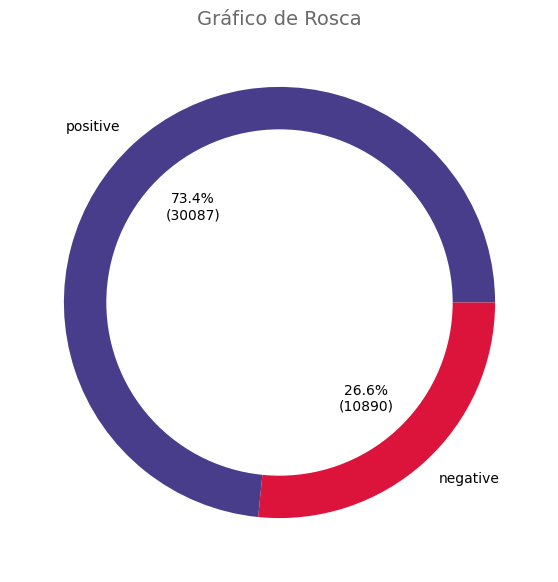

In [90]:
score_map = {
    1: 'negative',
    2: 'negative',
    3: 'positive',
    4: 'positive',
    5: 'positive'
}
df_comments['sentiment_label'] = df_comments['score'].map(score_map)

fig, ax = plt.subplots(figsize=(7, 7))
donut_plot(df_comments.query('sentiment_label in ("positive", "negative")'), 'sentiment_label', 
           label_names=df_comments.query('sentiment_label in ("positive", "negative")')['sentiment_label'].value_counts().index,
           ax=ax, colors=['darkslateblue', 'crimson'])

In [91]:
def ngrams_count(corpus, ngram_range, n=-1, cached_stopwords=stopwords.words('portuguese')):
    
    vectorizer = CountVectorizer(stop_words=cached_stopwords, ngram_range=ngram_range).fit(corpus)
    bag_of_words = vectorizer.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    total_list = words_freq[:n]
    
    count_df = pd.DataFrame(total_list, columns=['ngram', 'count'])
    return count_df

In [92]:
positive_comments = df_comments.query('sentiment_label == "positive"')['stemming']
negative_comments = df_comments.query('sentiment_label == "negative"')['stemming']

unigrams_pos = ngrams_count(positive_comments, (1, 1), 10)
unigrams_neg = ngrams_count(negative_comments, (1, 1), 10)

bigrams_pos = ngrams_count(positive_comments, (2, 2), 10)
bigrams_neg = ngrams_count(negative_comments, (2, 2), 10)

trigrams_pos = ngrams_count(positive_comments, (3, 3), 10)
trigrams_neg = ngrams_count(negative_comments, (3, 3), 10)

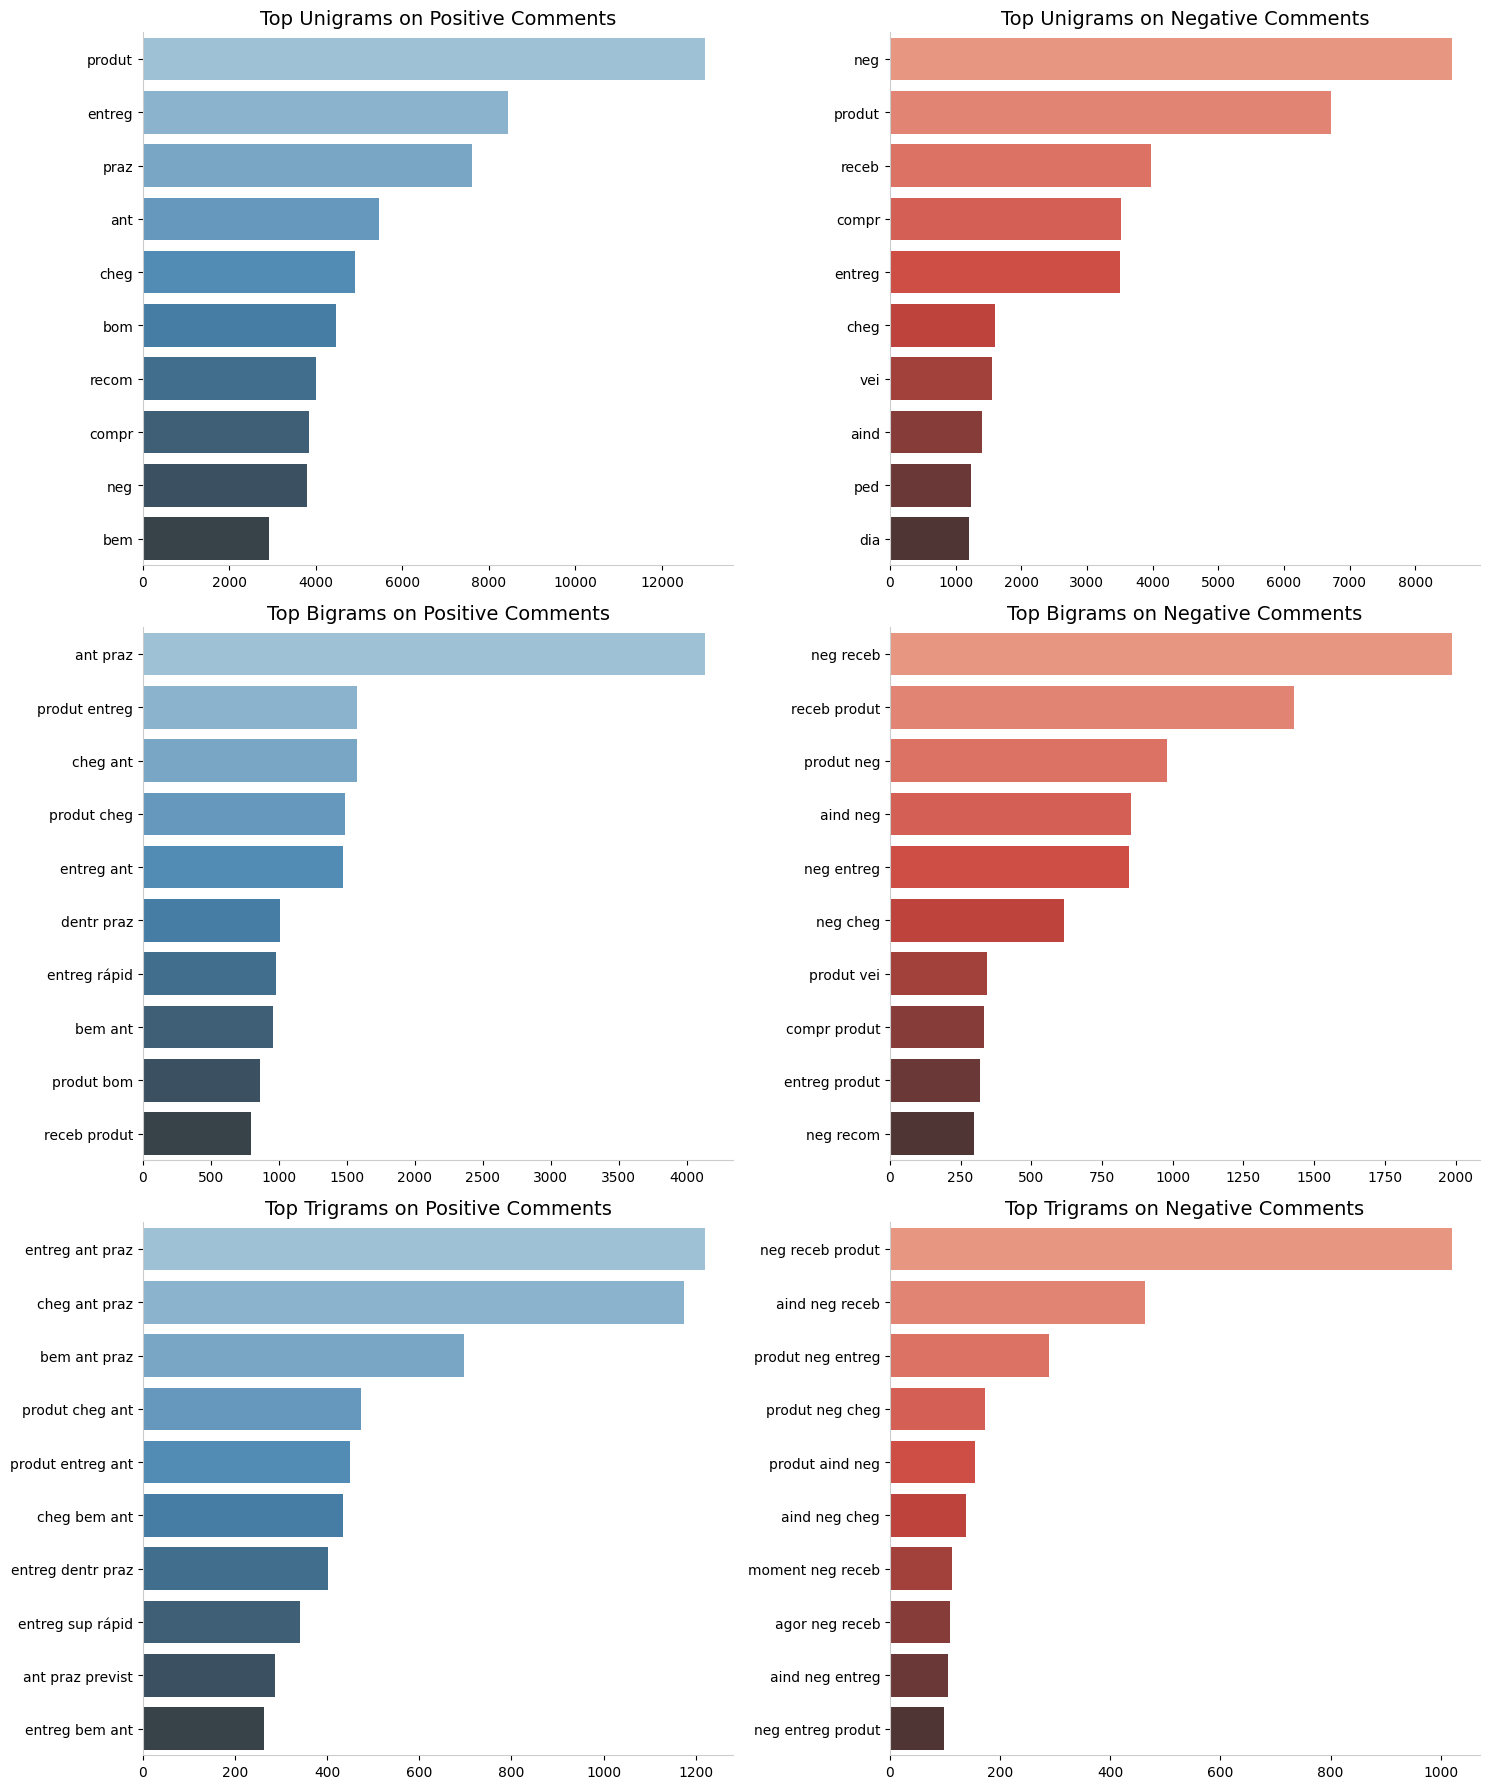

In [93]:
# Joining everything in a python dictionary to make the plots easier
ngram_dict_plot = {
    'Top Unigrams on Positive Comments': unigrams_pos,
    'Top Unigrams on Negative Comments': unigrams_neg,
    'Top Bigrams on Positive Comments': bigrams_pos,
    'Top Bigrams on Negative Comments': bigrams_neg,
    'Top Trigrams on Positive Comments': trigrams_pos,
    'Top Trigrams on Negative Comments': trigrams_neg,
}

# Plotting the ngrams analysis
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(15, 18))
i, j = 0, 0
colors = ['Blues_d', 'Reds_d']
for title, ngram_data in ngram_dict_plot.items():
    ax = axs[i, j]
    sns.barplot(x='count', y='ngram', data=ngram_data, ax=ax, palette=colors[j])
    
    # Customizing plots
    format_spines(ax, right_border=False)
    ax.set_title(title, size=14)
    ax.set_ylabel('')
    ax.set_xlabel('')
    
    # Incrementing the index
    j += 1
    if j == 2:
        j = 0
        i += 1
plt.tight_layout()
plt.show()

In [115]:
class ApplyRegex(BaseEstimator, TransformerMixin):
    
    def __init__(self, regex_transformers):
        self.regex_transformers = regex_transformers
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        for regex_name, regex_function in self.regex_transformers.items():
            X = regex_function(X)
            
        return X

class StopWordsRemoval(BaseEstimator, TransformerMixin):
    
    def __init__(self, text_stopwords):
        self.text_stopwords = text_stopwords
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stopwords_removal(comment, self.text_stopwords)) for comment in X]

class StemmingProcess(BaseEstimator, TransformerMixin):
    
    def __init__(self, stemmer):
        self.stemmer = stemmer
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return [' '.join(stemming_process(comment, self.stemmer)) for comment in X]
    
class TextFeatureExtraction(BaseEstimator, TransformerMixin):
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return self.vectorizer.fit_transform(X).toarray()

In [118]:
# Defining X and y 
idx_reviews = df['review_comment_message'].dropna().index
score = df['review_score'][idx_reviews].map(score_map)

# Splitting into train and test sets
X = list(df['review_comment_message'][idx_reviews].values)
y = score.apply(lambda x: 1 if x == 'positive' else 0).values

# Applying the pipeline and splitting the data
X_processed = text_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=.20, random_state=42)

# Verifying results
print(f'Length of X_train_processed: {len(X_train)} - Length of one element: {len(X_train[0])}')
print(f'Length of X_test_processed: {len(X_test)} - Length of one element: {len(X_test[0])}')

Length of X_train_processed: 32781 - Length of one element: 300
Length of X_test_processed: 8196 - Length of one element: 300


In [119]:
# Logistic Regression hyperparameters
logreg_param_grid = {
    'C': np.linspace(0.1, 10, 20),
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None],
    'random_state': [42],
    'solver': ['liblinear']
}

# Setting up the classifiers
set_classifiers = {
    'LogisticRegression': {
        'model': LogisticRegression(),
        'params': logreg_param_grid
    },
    'Naive Bayes': {
        'model': GaussianNB(),
        'params': {}
    }
}

In [132]:
# Creating an object and training the classifiers
clf_tool = BinaryClassifiersAnalysis()
clf_tool.fit(set_classifiers, X_train, y_train, random_search=True, scoring='accuracy')
#RandomizedSearchCV(model, parameters, cv=5, return_train_score=True, iid=True, n_iter = 4)

Training model LogisticRegression

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Training model Naive Bayes

Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [150]:
!pip freeze

absl-py==1.4.0
accelerate==0.34.2
aiobotocore==2.15.1
aiofiles==22.1.0
aiohttp @ file:///home/conda/feedstock_root/build_artifacts/aiohttp_1713964853148/work
aioitertools==0.12.0
aiosignal @ file:///home/conda/feedstock_root/build_artifacts/aiosignal_1667935791922/work
aiosqlite==0.20.0
albucore==0.0.17
albumentations==1.4.17
alembic==1.13.3
altair==5.4.1
annotated-types==0.7.0
annoy==1.17.3
ansicolors==1.1.8
anyio @ file:///home/conda/feedstock_root/build_artifacts/anyio_1717693030552/work
apache-beam==2.46.0
appdirs==1.4.4
archspec @ file:///home/conda/feedstock_root/build_artifacts/archspec_1708969572489/work
argon2-cffi @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi_1692818318753/work
argon2-cffi-bindings @ file:///home/conda/feedstock_root/build_artifacts/argon2-cffi-bindings_1695386546427/work
array_record==0.5.1
arrow @ file:///home/conda/feedstock_root/build_artifacts/arrow_1696128962909/work
arviz==0.20.0
astroid==3.3.4
asttokens @ file:///home/conda/feedstock

In [151]:
!python -V

Python 3.10.14
